<h1> Assignment 2. Explaining Model Predictions to Users </h1>
<h3> Stage 2. Implementing an algorithm to explain the model prediction in image classification tasks </h3>

In this stage, you are asked to complete an algorithm that explains the model's prediction in image classification tasks. What we mean by explanation here is the visual information on which parts of the image contributed to the prediction results. For example, let's refer to the following image where our model classified it as a "dog".

<img src='https://raw.githubusercontent.com/yougatup/figures/main/dog.jpg' width='300'/>

Even if it is correctly classified, the user might wonder why the model predicted in that way. In other words, the user may wonder which parts of the image contributed to the prediction results. If it turns out that the background area contributed other than the dog itself, then it's reasonable for the user to think our model is not working well even if the classification result was right. 

In this Activity, your task is to implement an algorithm to show the parts of a source image that contribute to the classification result, which helps users to interpret the prediction results. One of the examples is the following :

![Dog explained image](https://raw.githubusercontent.com/yougatup/figures/main/dog_explained.png)

In this example, it looks like our model classified the original image as "dog" by looking at part of the face and the ear. It makes sense to think that the model is working well because looking at these features for the prediction makes sense.




---


To guide you complete the algorithm, we are going to tell you how the algorithm works. You will be asked to fill some blanks to make it work. The algorithm is introduced in the LIME paper [1]. The high-level idea around the algorithm as well as the whole assignment is explained [in our assignment page](https://www.kixlab.org/courses/cs492-fall-2020/assignments.html) to help you quickly understand the goal of this Activity. You can refer to the paper if you need more details.

---

**Activity 1**: You first need to set up classification algorithm.

- Preparing pretrained model (Inception V3) for image classification

- Conducting image preprocessing 

- Conducting classification prediction

Next, you need to do **four Tasks**.

- Build an explanation of the model prediction

  - Step 1. Extract superpixels from image

  - Step 2. Create perturbed data     **(Task 1)**

  - Step 3. Make a prediction on the perturbed data with the original model

  - Step 4. Compute weights between the original image and perturbed images

  - Step 5. Fit a linear model        **(Task 2)**

  - Step 6. Feature selection         **(Task 3)**

  - Step 7. Visualize the result

- **Activity 2**: Compare explanations of multiple images **(Task 4)**


Let's go to the code below. We are going to give explanations as well.

---

**References**

[1] Ribeiro et al., [""Why Should I Trust You?": Explaining the Predictions of Any Classifier"](https://arxiv.org/pdf/1602.04938.pdf), Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining. 2016

## Activity 1: Set up classification algorithm

In [3]:
# Setup

%tensorflow_version 1.x
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings
from ipywidgets import interact


print('Notebook running: keras ', keras.__version__)
np.random.seed(222) # for consistent results

TensorFlow 1.x selected.


Using TensorFlow backend.


Notebook running: keras  2.3.1


### Using pretrained Inception V3 model for image classification

In this assignment, we are going to use Inception V3 model, a convolutional neural network for image recognitions developed by Google. There is a pre-trained model available in Keras, so we'll use the model without doing training ourselves. 

Let's load the pretrained model below :

In [4]:
warnings.filterwarnings('ignore') 
inceptionV3_model = keras.applications.inception_v3.InceptionV3() #Load pretrained model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


96116736/96112376 [==============================] - 3s 0us/step


### Image preprocessing

Now we have the model ready. Let's do a classification with an example image. To do this, we need to preprocess the image to feed it to the model. What we need to do is resizing. The size of the image should be 299 x 299. 

Note that you can try this prediction with your own image. To do that, you need to upload your image first. On the left tab, you can see the file icon <img src='https://raw.githubusercontent.com/yougatup/figures/main/file_icon.png' width=20 />. Upload your own image to play with. Specify your image path into the `img_path`. Then `img` is going to be the image, which is shown as an output below after the resizing.

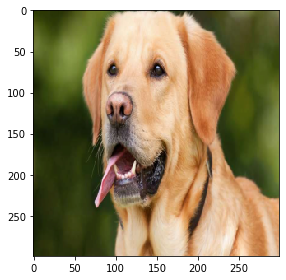

In [90]:
img_path = 'https://raw.githubusercontent.com/yougatup/figures/main/dog.jpg'

# The path of current folder of the left plane is '/content/'. 
# Therefore, if the filename of your image is 'cat.jpg', then
# the path should be '/content/cat.jpg'

img = skimage.io.imread(img_path)
img = skimage.transform.resize(img, (299, 299))
img = (img - 0.5) * 2     # preprocessing that inception v3 recommends

skimage.io.imshow(img/2+0.5)

### Make a prediction

Now let's make a prediction with the source image. We simply feed the image to the model and get the top 5 classes that the source image is predicted to be in.

In [91]:
predicted = inceptionV3_model.predict(img[np.newaxis,:,:,:])
print(decode_predictions(predicted, top=5)[0]) # Give top 5 classes

predicted_top_labels = predicted[0].argsort()[-5:][::-1]
print(predicted_top_labels)


[('n02099712', 'Labrador_retriever', 0.67039126), ('n02099601', 'golden_retriever', 0.24134567), ('n04409515', 'tennis_ball', 0.0037141663), ('n02104029', 'kuvasz', 0.002534105), ('n02101556', 'clumber', 0.0016600089)]
[208 207 852 222 216]


 The model says it is "Labrador retriever" with the corresponding probability. Now, let's say the user is curious why model predicted the image as "Labrador retriever". In other words, which parts of the image did the model focus on to classify it as "Labrador retriever"? Is it simply just a background? or the ear? or the entire face?

## Start of the Four Main Tasks

### Build an explanation of the model prediction

One of the challenges in building an explanation is that the features used in the model can be highly complex and not interpretable as quoted from the paper [1] : 

> "**interpretable** explanations need to use a representation that is understandable to humans, regardless of the actual features used by the model."

Then the question is how to build such interpretable representation? The high-level insight is that we can build a simple interpretable model, such as a linear regression model, that is locally similar to the original complex model, the Inception v3 in our example. You need to understand two keywords: "locally" and "similar". Refer to the explanations in the original paper [1] if needed.

We can say two classifiers are similar if their prediction results are similar. (We are not going to define the exact concept of similar here.) For example, if we classified 10 images and 9 out of 10 prediction results were the same for two classifiers. Then we could say two classifiers are similar.

Our goal for building an explanation is to build a similar but simple, interpretable model and use this to explain the result of the complicated model. 

However, it is impossible for the simple model to behave similarly to the original complex model globally. For example, a linear regression model is not likely to behave as similar to the complex convolutional neural network model. Instead, we build the simple model that behaves similarly **locally around the source image that we are interested in**. In other words, we are not interested in how the simple model performs for images like cats, horses, etc. You can think of it as coming up with a linear function to approximate a quadratic function around a specific value of x.

The following figure is from the paper [1], which describes this insights.

<img src='https://raw.githubusercontent.com/yougatup/figures/main/lime_fig.png' width=500 />

So far, we've explained the meaning of "similar" and "locally". Now, what you need to do is the following :

(1) You are going to use a linear regression model as the simple model. In other words, you are going to build a linear regression model that behaves similarly to Inception V3 around the source image. Note that one of the core questions here is how to populate data around the source image. The details on how to build such a model are going to be explained below.

(2) After training the linear regression model, we'll regard the feature importance as an interpretable representation.

#### Step 1. Extract superpixels from image

To use the linear regression, we are going to first decompose the image into a set of superpixels. Each superpixel occupies a certain part of the image. Each superpixel is going to be a feature of the source image.

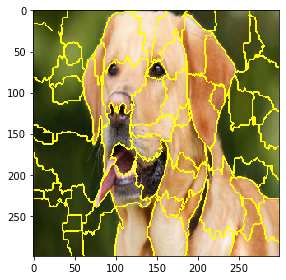

In [92]:
# Adopt quickshift segmentation algorithm on your image with kernel_size = 4, max_dist = 2000, ratio = 0.2.

superpixels = skimage.segmentation.quickshift(img, kernel_size=4,max_dist=200, ratio=0.2)
num_features = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(img/2+0.5, superpixels))

#### Step 2. Create perturbed data.   **(Task 1)**

Now, the question is how to populate data around the original image. We simply select a set of random superpixels generated above and construct an image. We'll call the image as "a perturbed data". i.e., each perturbed data consists of a set of randomly selected superpixels. The following are three examples of "a perturbed data".

<img src='https://github.com/yougatup/figures/raw/main/purturbed.png' />

In this task, you need to finish the function `gen_perturbed_images` that returns an image with a set of randomly selected superpixels. The detailed pre and post conditions are the followings:

---

*Preconditions*

 `img`:              the original image

`purturbation`:     a numpy array that specifies superpixels that need to be selected. `purturbation[i] = 1` if i-th superpixel needs to be selected.

`superpixels` : a matrix that specifies indexes of superpixels. `superpixels[i][j]=c` if the `(i, j)` of the original image belongs to the superpixel `c`.

*Postconditions* 

an image that consists of the superpixels



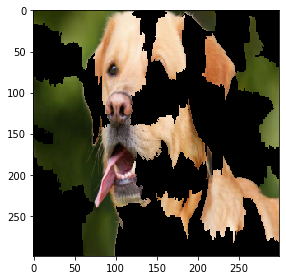

In [93]:
num_samples = 150

# Randomly select a set of superpixels
np.random.seed(222)
perturbations = np.random.binomial(1, 0.5, size=(num_samples, num_features))

def perturb_image(img,perturbation,segments):

  output = np.zeros((img.shape[0],img.shape[1],img.shape[2]))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      seg = segments[i][j]
      if (perturbation[segments[i][j]] == 1):
        output[i,j,:] += img[i,j,:]
  return output

skimage.io.imshow(perturb_image(img/2+0.5,perturbations[0],superpixels))

#### Step 3. Make a prediction on the perturbed data with the original model

To build the linear regression model, we need to have both data and value. In our case, the data is the perturbed data, and the value is going to be the probability that our original complex model (Inception v3) predicts it as the class of the original image ("Labrador retriever", in our example). The following function `predict_perturbed_data` makes predictions on the perturbed images.


In [94]:
def predict_perturbed_data(img, perturbations, superpixels, classifier_fn):
  perturbed_pred = []
  for pert in perturbations:
    perturbed_img = perturb_image(img,pert,superpixels)
    pred = classifier_fn.predict(perturbed_img[np.newaxis,:,:,:])
    perturbed_pred.append(pred)
  return np.array(perturbed_pred)

perturbed_pred = predict_perturbed_data(img, perturbations, superpixels,inceptionV3_model)
perturbed_pred.shape

(150, 1, 1000)

#### Step 4. Compute weights between the original image and perturbed images

In addition, we want to consider more close perturbed images as more important.

To do this, we are going to compute the distance between the purturbed images and the original image, and use it as a weight for linear regression.

Also, we will map the distance to a value in the range of (0, 1) so that we can use the coefficient of linear regression as the feature importance. 

In [95]:
# 1) Compute distance between original images and perturbed images using a cosine and l2 distance 
#    You can use other various distance metrics here as well.

raw_image_features = np.ones(num_features)[np.newaxis,:] #Perturbation with all superpixels enabled 
cosine_distances = sklearn.metrics.pairwise_distances(perturbations,raw_image_features, metric='cosine').ravel()
l2_distances = sklearn.metrics.pairwise_distances(perturbations,raw_image_features, metric='l2').ravel()

# 2) Compute weights using kernel function that maps distances to a values (weights) in (0,1)
#    You can use other kernels for the mapping.

kernel_width = 0.25
weights = np.sqrt(np.exp(-(cosine_distances**2)/kernel_width**2)) #Kernel function

weights.shape


(150,)

#### Step 5. Fit a linear model **(Task 2)**

Let's fit the linear model. The input is a matrix representing indexes of superpixels that perturbed data includes. The output is the probability that the original complex model predicted it as the class of the original image. We also have a weight that describes the distance between the perturbed image and the original image.

In this task, you need to complete the function `get_linear_coefficient` which returns the coefficients of the trained linear regression model. The detailed pre and post conditions are the following :

---

*Preconditions* :

`X`: the training data. In our example, it is `perturbations` which denotes which superpixels are selected for perturbed images.

`y`: the label. In our example, it is `perturbed_pred[:, :, class_to_explain`] which means the probability or being classified as the class that the original image belongs to.

`w`: the weight. In our example, it is `weights` that we computed previously. i.e. each perturbed image will have a single weight.

*Postcondition* :

the coefficient of the trained linear regression model.

In [96]:
class_to_explain = predicted_top_labels[0]

def get_linear_coefficient(X, y, w) :
  return LinearRegression().fit(X, y, sample_weight = w).coef_;

coeff = get_linear_coefficient(perturbations, perturbed_pred[:, :, class_to_explain], weights);

# Note that the number of coefficients should be the same as the number of features.


#### Step 6. Feature selection **(Task 3)**

Select the features that are important for the classification. As each feature represents a single superpixel, the important features could mean important superpixels that contributed to the classification results. 

In this task, you need to finish the function `get_features` that returns a list of important features. You can use existing techniques to compute the feature importance.

---

*Preconditions*

`num_features` : the number of features that needs to be selected

`coeff` : the coefficients of the trained linear regression model

*Postconditions*

a list of indexes of important features. The number of features should be the same as `num_features`.


In [97]:
num_selected_features = 4

def get_features(num_features, coeff) :
  return np.flip(coeff.argsort(), axis=None)[0][:num_features]

selected_features = get_features(num_selected_features, coeff)
print(selected_features)

[18 20 23  3]


#### Step 7. Visualize the result

Let's show the chosen superpixels. Then we can see what are important parts of the image for the classification result.

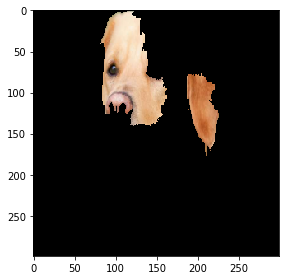

In [98]:
mask = np.zeros(num_features) 
mask[selected_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(img/2+0.5,mask,superpixels) )

### Activity 2: Compare explanations of multiple images **(Task 4)**

So far, we have been building algorithms for explaining the predictions of the model. In this activity, 

(1) pick 5 images that are predicted as the same classes. You may want to search for images on the web. 

(2) Get an explanation using the code that we've written. 

(3) Compare how different relevant features each image has. You may want to discuss this in the report. 

Also, it is highly encouraged to try various images and have interesting observations!

In [88]:
def runAll(link, num_selected_features):
  img_path = link

  # The path of current folder of the left plane is '/content/'. 
  # Therefore, if the filename of your image is 'cat.jpg', then
  # the path should be '/content/cat.jpg'

  img = skimage.io.imread(img_path)
  img = skimage.transform.resize(img, (299, 299))
  img = (img - 0.5) * 2     # preprocessing that inception v3 recommends
  predicted = inceptionV3_model.predict(img[np.newaxis,:,:,:])
  predicted_top_labels = predicted[0].argsort()[-5:][::-1]

  # Adopt quickshift segmentation algorithm on your image with kernel_size = 4, max_dist = 2000, ratio = 0.2.

  superpixels = skimage.segmentation.quickshift(img, kernel_size=4,max_dist=200, ratio=0.2)
  num_features = np.unique(superpixels).shape[0]
  skimage.io.imshow(skimage.segmentation.mark_boundaries(img/2+0.5, superpixels))
  num_samples = 150

  # Randomly select a set of superpixels
  np.random.seed(222)
  perturbations = np.random.binomial(1, 0.5, size=(num_samples, num_features))
  skimage.io.imshow(perturb_image(img/2+0.5,perturbations[0],superpixels))
  
  perturbed_pred = predict_perturbed_data(img, perturbations, superpixels,inceptionV3_model)
  perturbed_pred.shape
  # 1) Compute distance between original images and perturbed images using a cosine and l2 distance 
  #    You can use other various distance metrics here as well.

  raw_image_features = np.ones(num_features)[np.newaxis,:] #Perturbation with all superpixels enabled 
  cosine_distances = sklearn.metrics.pairwise_distances(perturbations,raw_image_features, metric='cosine').ravel()
  l2_distances = sklearn.metrics.pairwise_distances(perturbations,raw_image_features, metric='l2').ravel()

  # 2) Compute weights using kernel function that maps distances to a values (weights) in (0,1)
  #    You can use other kernels for the mapping.

  kernel_width = 0.25
  weights = np.sqrt(np.exp(-(cosine_distances**2)/kernel_width**2)) #Kernel function

  weights.shape

  class_to_explain = predicted_top_labels[0]

  coeff = get_linear_coefficient(perturbations, perturbed_pred[:, :, class_to_explain], weights);

  selected_features = get_features(num_selected_features, coeff)
  
  mask = np.zeros(num_features) 
  mask[selected_features]= True #Activate top superpixels
  return skimage.io.imshow(perturb_image(img/2+0.5,mask,superpixels) )
interact(runAll, link='https://i.guim.co.uk/img/media/684c9d087dab923db1ce4057903f03293b07deac/205_132_1915_1150/master/1915.jpg?width=1200&height=1200&quality=85&auto=format&fit=crop&s=14a95b5026c1567b823629ba35c40aa0', num_selected_features=4)

In [107]:
def showImage(link):
  img_path = link

  # The path of current folder of the left plane is '/content/'. 
  # Therefore, if the filename of your image is 'cat.jpg', then
  # the path should be '/content/cat.jpg'

  img = skimage.io.imread(img_path)
  img = skimage.transform.resize(img, (299, 299))
  img = (img - 0.5) * 2     # preprocessing that inception v3 recommends

  skimage.io.imshow(img/2+0.5)

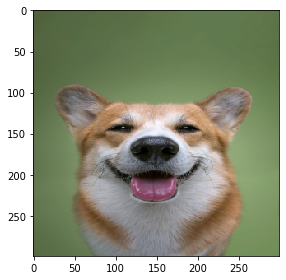

In [108]:
showImage('https://i.pinimg.com/originals/b6/dd/c3/b6ddc3f00b8b642bcb6b6fd2929d7508.jpg')

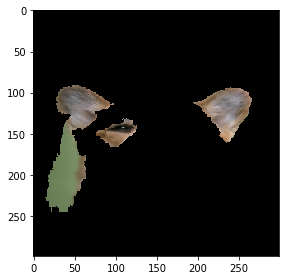

In [114]:
runAll("https://i.pinimg.com/originals/b6/dd/c3/b6ddc3f00b8b642bcb6b6fd2929d7508.jpg", 4)

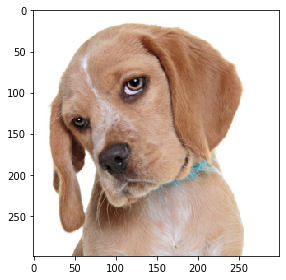

In [110]:
showImage('https://i.guim.co.uk/img/media/684c9d087dab923db1ce4057903f03293b07deac/205_132_1915_1150/master/1915.jpg?width=1200&height=1200&quality=85&auto=format&fit=crop&s=14a95b5026c1567b823629ba35c40aa0')

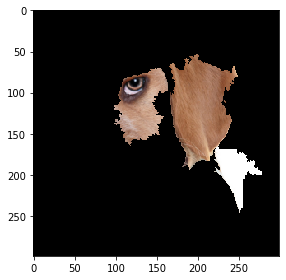

In [102]:
runAll('https://i.guim.co.uk/img/media/684c9d087dab923db1ce4057903f03293b07deac/205_132_1915_1150/master/1915.jpg?width=1200&height=1200&quality=85&auto=format&fit=crop&s=14a95b5026c1567b823629ba35c40aa0', 4)

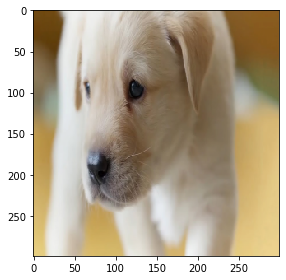

In [111]:
showImage('https://i.ytimg.com/vi/MPV2METPeJU/maxresdefault.jpg')

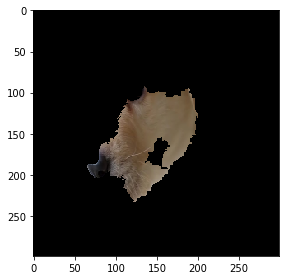

In [100]:
runAll('https://i.ytimg.com/vi/MPV2METPeJU/maxresdefault.jpg',4)

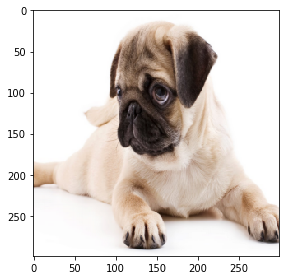

In [112]:
showImage('https://i.guim.co.uk/img/media/fe1e34da640c5c56ed16f76ce6f994fa9343d09d/0_174_3408_2046/master/3408.jpg?width=1200&height=900&quality=85&auto=format&fit=crop&s=0d3f33fb6aa6e0154b7713a00454c83d')

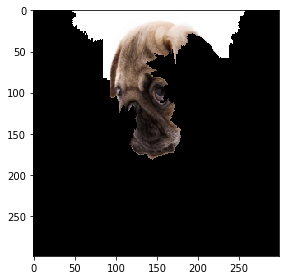

In [101]:
runAll('https://i.guim.co.uk/img/media/fe1e34da640c5c56ed16f76ce6f994fa9343d09d/0_174_3408_2046/master/3408.jpg?width=1200&height=900&quality=85&auto=format&fit=crop&s=0d3f33fb6aa6e0154b7713a00454c83d',4)

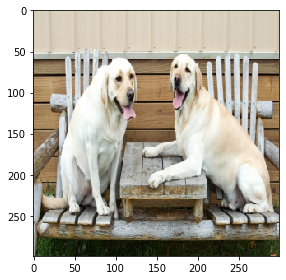

In [113]:
showImage('https://www.sciencenews.org/wp-content/uploads/2020/07/070720_bo_dogage_feat-1028x579.jpg')

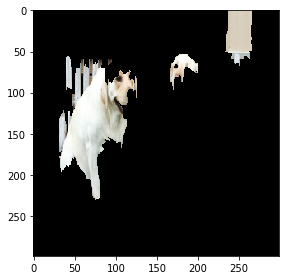

In [115]:
runAll('https://www.sciencenews.org/wp-content/uploads/2020/07/070720_bo_dogage_feat-1028x579.jpg', 4)